In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
from sklearn.metrics import r2_score
import scipy.stats.kde as kde

# Read meta data (remove mice with suffix 4)

In [2]:
df_meta = pd.read_excel('../../../../../../../data/meta_data.xlsx', index_col=0)

# change HI5 to HI3
df_meta.loc[df_meta.MiceID=='HI5','MiceID'] = 'HI3'

df_meta = df_meta[~df_meta.MiceID.str.contains('4')]
df_meta = df_meta[df_meta.Diet == 'Inulin']
df_meta.head()

,MiceID,Vendor,Day,Diet
SampleID,,,,
sample141,BI1,Beijing,0,Inulin
sample142,BI2,Beijing,0,Inulin
sample143,BI3,Beijing,0,Inulin
sample145,BI5,Beijing,0,Inulin
sample156,BI1,Beijing,1,Inulin


# Read SCFA

In [3]:
df_scfa = pd.read_excel('../../../../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
common_samples = [x for x in df_meta.index if x in list(df_scfa.index)]
df_scfa = df_scfa.loc[common_samples]
df_meta = df_meta.loc[common_samples]
df_scfa.head()

,Acetate,Butyrate,Propionate
SampleID,,,
sample141,5.233899,1.109582,1.930933
sample142,13.459823,1.546647,3.621771
sample143,18.075378,1.682656,2.859916
sample145,8.065127,1.835172,3.134209
sample156,14.944810,5.382770,11.384803


In [4]:
df_scfa.corr()

,Acetate,Butyrate,Propionate
Acetate,1.000000,0.549807,0.518400
Butyrate,0.549807,1.000000,0.243709
Propionate,0.518400,0.243709,1.000000


# Read 16S data

In [5]:
df_16S = pd.read_excel('../../../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S = df_16S.loc[df_meta.index]
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S.head()

,A2,ASF356,Acetatifactor,Acetatifactor_dash_muris,Acidovorax,Acinetobacter,Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2,Acutalibacter_dash_muris,Adlercreutzia_dash_mucosicola,Adlercreutzia_dash_muris,...,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_torques_dash_group,bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153,gut_dash_metagenome,human_dash_gut_dash_metagenome,marine_dash_metagenome,metagenome,mouse_dash_gut_dash_metagenome
SampleID,,,,,,,,,,,,,,,,,,,,,
sample141,0.000000,58318.686780,98146.082630,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,49784.244812,0.0,0.0,0.0,200559.386244,0.000000,0.000000,0.0,2.076714e+05
sample142,79938.738108,25274.748078,33503.735825,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18809.114849,0.0,0.0,0.0,48198.356800,0.000000,1763.354517,0.0,1.081524e+05
sample143,0.000000,137987.686312,64115.490610,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,58540.230557,0.0,0.0,0.0,167257.801590,0.000000,0.000000,0.0,2.717939e+05
sample145,0.000000,122899.454628,119532.346282,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,69025.721092,0.0,0.0,0.0,368698.363883,0.000000,0.000000,0.0,7.407638e+04
sample156,0.000000,182420.266467,194421.599787,4800.533328,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,24002.666640,2400.266664,0.000000,0.0,1.101722e+06


# Select the 40 most abundant taxa

In [6]:
topX = 40
df_16S_T = df_16S.T
df_16S_T['mean'] = df_16S_T.mean(axis=1)
df_16S_T = df_16S_T.sort_values(by=['mean'],axis=0,ascending=False)
df_16S_T = df_16S_T.drop('mean', axis=1)
df_16S_topX = df_16S_T.iloc[0:topX].T
df_16S_topX.head()

,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Faecalibaculum,Parasutterella,Bacteroides_dash_uniformis,Bacteroides,Alloprevotella,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_NK4A136_dash_group,...,Parabacteroides,Lactobacillus,Ruminococcaceae,Bilophila,Gastranaerophilales,Anaerotruncus,mouse_dash_gut_dash_metagenome,Ruminococcus_dash_sp_dot__dash_N15_dot_MGS_dash_57,Desulfovibrio,Bifidobacterium_dash_choerinum
SampleID,,,,,,,,,,,,,,,,,,,,,
sample141,2.558057e+07,2.803564e+06,7.311172e+05,1.503484e+07,6.520314e+06,19913.697925,3.797827e+05,6.841778e+05,1.877577e+05,5.789196e+05,...,1.934474e+05,1.069650e+06,641505.554582,2.361196e+05,2.474988e+05,3.442225e+05,2.076714e+05,9956.848962,0.000000,98146.082630
sample142,1.221770e+07,1.240226e+05,1.518836e+06,8.628681e+06,1.957324e+06,17045.760332,2.697932e+05,1.537645e+06,5.207774e+05,9.469214e+05,...,9.874785e+04,6.060062e+05,432021.856685,3.174038e+05,3.996937e+04,1.610530e+05,1.081524e+05,3526.709034,4114.493873,38206.014537
sample143,2.765050e+07,3.721486e+05,1.919005e+07,7.158634e+06,4.014187e+05,27876.300265,2.028001e+06,3.982826e+07,1.076025e+06,1.998731e+06,...,7.668770e+06,5.658889e+05,682969.356493,9.617324e+04,2.313733e+05,9.700952e+05,2.717939e+05,25088.670239,33451.560318,0.000000
sample145,4.461250e+07,6.279657e+05,3.589337e+06,1.075791e+07,7.912705e+04,40405.300152,3.833453e+06,2.133737e+07,1.880530e+06,2.452938e+06,...,4.865472e+05,3.198753e+04,590927.514717,1.144817e+05,1.188589e+06,5.825097e+05,7.407638e+04,8417.770865,43772.408498,0.000000
sample156,6.293019e+07,2.520280e+05,6.328303e+07,5.762800e+07,8.175308e+06,67207.466593,1.785798e+06,1.848205e+05,8.160907e+04,1.022754e+07,...,4.560507e+04,4.536504e+05,228025.333084,1.644183e+06,1.680187e+04,1.032115e+06,1.101722e+06,0.000000,14401.599984,48005.333281


In [7]:
df_16S_topX.to_csv('independent_variables_top40.csv')

In [8]:
# sample with minimum absolute abundance coverage
(df_16S_topX.sum(axis=1)/df_16S.sum(axis=1)).min()

0.8219972118277203

# Calculate derivative

In [9]:
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv = deepcopy(df_scfa_meta)
for curr_mice in set(df_scfa_deriv.MiceID):
    curr_df = df_scfa_meta[df_scfa_meta.MiceID==curr_mice].sort_values(by='Day')
    for scfa in ['Acetate','Butyrate','Propionate']:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[scfa])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_scfa_deriv.loc[df_scfa_deriv.MiceID==curr_mice, scfa] = ydata_d1
    
df_scfa_deriv = df_scfa_deriv[['Acetate','Butyrate','Propionate']]
df_scfa_deriv.head()

,Acetate,Butyrate,Propionate
SampleID,,,
sample141,5.880802,4.401419,12.404128
sample142,18.463945,6.679364,18.569295
sample143,23.205175,10.299538,27.076697
sample145,8.669110,4.911881,1.435425
sample156,12.145962,3.952820,6.676380


In [10]:
df_scfa_deriv.to_csv('response_variables_scfa_deriv.csv')

# Normalize max value of 16S data to 1

In [11]:
# normalize bacteria data using 
bacterial_taxa = list(df_16S_topX.columns)
df_16S_topX = df_16S_topX/df_16S_topX.max().max()
df_16S_topX.head()

,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Faecalibaculum,Parasutterella,Bacteroides_dash_uniformis,Bacteroides,Alloprevotella,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_NK4A136_dash_group,...,Parabacteroides,Lactobacillus,Ruminococcaceae,Bilophila,Gastranaerophilales,Anaerotruncus,mouse_dash_gut_dash_metagenome,Ruminococcus_dash_sp_dot__dash_N15_dot_MGS_dash_57,Desulfovibrio,Bifidobacterium_dash_choerinum
SampleID,,,,,,,,,,,,,,,,,,,,,
sample141,0.068811,0.007541,0.001967,0.040443,0.017539,0.000054,0.001022,0.001840,0.000505,0.001557,...,0.000520,0.002877,0.001726,0.000635,0.000666,0.000926,0.000559,0.000027,0.000000,0.000264
sample142,0.032865,0.000334,0.004086,0.023211,0.005265,0.000046,0.000726,0.004136,0.001401,0.002547,...,0.000266,0.001630,0.001162,0.000854,0.000108,0.000433,0.000291,0.000009,0.000011,0.000103
sample143,0.074379,0.001001,0.051620,0.019256,0.001080,0.000075,0.005455,0.107136,0.002894,0.005376,...,0.020629,0.001522,0.001837,0.000259,0.000622,0.002610,0.000731,0.000067,0.000090,0.000000
sample145,0.120006,0.001689,0.009655,0.028938,0.000213,0.000109,0.010312,0.057397,0.005059,0.006598,...,0.001309,0.000086,0.001590,0.000308,0.003197,0.001567,0.000199,0.000023,0.000118,0.000000
sample156,0.169279,0.000678,0.170228,0.155017,0.021991,0.000181,0.004804,0.000497,0.000220,0.027512,...,0.000123,0.001220,0.000613,0.004423,0.000045,0.002776,0.002964,0.000000,0.000039,0.000129


# Simple Correlation

In [12]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    for t in bacterial_taxa:
        lines.append([scfa,
                     t,
                     pearsonr(df_scfa_deriv[scfa],df_16S_topX[t])[0],
                     spearmanr(df_scfa_deriv[scfa],df_16S_topX[t])[0]]
                    )
df_corr = pd.DataFrame(lines, columns=['SCFA','Variable','Pearson','Spearman'])
df_corr.head()

,SCFA,Variable,Pearson,Spearman
0,Acetate,Muribaculaceae,-0.252873,-0.209436
1,Acetate,Akkermansia_dash_muciniphila,-0.129561,-0.064612
2,Acetate,Bacteroides_dash_acidifaciens,0.006933,0.026021
3,Acetate,Faecalibaculum,-0.204028,-0.108495
4,Acetate,Parasutterella,-0.197488,-0.214131


In [13]:
df_corr.to_excel('correlation_top40.xlsx')

# Elastic net

In [14]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    l1_ratio = [1e-4, .1, .3, .5, .7, .9, .95, .99, 1]
    reg = ElasticNetCV(
        eps=1e-4,
        n_alphas=10000,
        cv=5,
        random_state=0,
        max_iter=100000,
        tol=1e-6,
        l1_ratio=l1_ratio
    ).fit(X, dydt)
    clf = ElasticNet(l1_ratio=reg.l1_ratio_, 
                     alpha=reg.alpha_, 
                     random_state=0,
                     max_iter=100000,
                     tol=1e-6,
                    ).fit(X,dydt)
    rows.append([scfa, reg.alpha_, reg.l1_ratio_, clf.score(X,dydt)]+ list(clf.coef_))
df_elasticnet = pd.DataFrame(rows, columns=['SCFA','BestAlpha','L1Ratio','R2']+list(df_16S_topX.columns)).set_index('SCFA')
df_elasticnet = df_elasticnet.loc[:, (df_elasticnet != 0).any(axis=0)]
df_elasticnet.head()

,BestAlpha,L1Ratio,R2,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Faecalibaculum,Parasutterella,Bacteroides_dash_uniformis,Bacteroides,...,Parabacteroides,Lactobacillus,Ruminococcaceae,Bilophila,Gastranaerophilales,Anaerotruncus,mouse_dash_gut_dash_metagenome,Ruminococcus_dash_sp_dot__dash_N15_dot_MGS_dash_57,Desulfovibrio,Bifidobacterium_dash_choerinum
SCFA,,,,,,,,,,,,,,,,,,,,,
Acetate,0.329063,0.0001,0.019435,-0.847048,-0.169171,0.023936,-0.159894,-0.097900,-0.137617,-0.035420,...,0.014736,0.002406,-0.000000,-0.007245,0.000142,0.006429,0.000763,-0.003892,0.000035,-0.007093
Butyrate,0.273409,0.0001,0.034889,-0.571969,-0.124834,0.015011,-0.081712,-0.078647,-0.068864,-0.022815,...,0.009266,0.000513,0.001526,-0.006780,-0.002712,0.003125,-0.001881,-0.005961,-0.000621,-0.004171
Propionate,0.135643,0.1000,0.043501,-1.572633,-0.350716,0.064285,-0.138810,-0.100608,-0.111285,-0.046541,...,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000


In [15]:
df_elasticnet = df_elasticnet.stack().reset_index()
df_elasticnet = df_elasticnet[~df_elasticnet.level_1.isin(['BestAlpha','L1Ratio','R2'])]
df_elasticnet.columns=['SCFA','Variable','Coefficient']
df_elasticnet = df_elasticnet.reset_index(drop=True)
df_elasticnet.to_excel('elasticnet_summary_top40.xlsx')

# Random forest regression

## parameter optimization

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)

    # grid search
    rf = RandomForestRegressor()
    rf_random = GridSearchCV(
        estimator = rf, 
        param_grid = random_grid, 
        cv = 5, 
        verbose=2, 
        n_jobs = -1)

    # fit the random search model
    rf_random.fit(X, dydt)
    
    # write to table
    lines.append([scfa,
           rf_random.best_params_['n_estimators'],
           rf_random.best_params_['max_features'],
           rf_random.best_params_['max_depth'],
           rf_random.best_params_['min_samples_split'],
           rf_random.best_params_['min_samples_leaf'],
           rf_random.best_params_['bootstrap']
           ])

df_opt_paras = pd.DataFrame(lines, columns=['SCFA','n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap'])
df_opt_paras.head()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 49.8min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 345.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 355.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 368.5min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 377.4min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 52.0min finished


,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,200,sqrt,10.0,2,1,True
1,Butyrate,200,sqrt,10.0,5,2,True
2,Propionate,200,auto,NaN,2,2,True


In [17]:
df_opt_paras.to_excel('optimal_rf_hyperparameters_top40.xlsx')

## run RF using best parameters

In [18]:
df_opt_paras = pd.read_excel('optimal_rf_hyperparameters_top40.xlsx', index_col=0)
df_opt_paras.head()

,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,200,sqrt,10.0,2,1,True
1,Butyrate,200,sqrt,10.0,5,2,True
2,Propionate,200,auto,NaN,2,2,True


In [19]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    rows.append([scfa, clf.score(X, dydt)]+ list(clf.feature_importances_))
df_rf = pd.DataFrame(rows, columns=['SCFA','R2']+list(df_16S_topX.columns))
df_rf.head()

,SCFA,R2,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Faecalibaculum,Parasutterella,Bacteroides_dash_uniformis,Bacteroides,Alloprevotella,...,Parabacteroides,Lactobacillus,Ruminococcaceae,Bilophila,Gastranaerophilales,Anaerotruncus,mouse_dash_gut_dash_metagenome,Ruminococcus_dash_sp_dot__dash_N15_dot_MGS_dash_57,Desulfovibrio,Bifidobacterium_dash_choerinum
0,Acetate,0.879543,0.047456,0.021671,0.020903,0.033197,0.060539,0.021092,0.026122,0.029249,...,0.046393,0.017499,0.022045,0.012851,0.008673,0.032743,0.018349,0.013150,0.011714,0.005708
1,Butyrate,0.824279,0.100246,0.029160,0.016711,0.035582,0.087416,0.027211,0.011970,0.037188,...,0.042702,0.012699,0.020422,0.004329,0.006907,0.015981,0.007522,0.009363,0.011553,0.005836
2,Propionate,0.840844,0.029659,0.004218,0.019984,0.029646,0.072815,0.015250,0.021238,0.010823,...,0.253792,0.014776,0.012691,0.003264,0.002136,0.005532,0.010944,0.002941,0.003607,0.000275


In [20]:
df_rf = df_rf.set_index('SCFA').stack().reset_index()
df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
df_rf.columns=['SCFA','Variable','Gini']
df_rf = df_rf.reset_index(drop=True)
df_rf.to_excel('rf_importance_top40.xlsx')

## plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


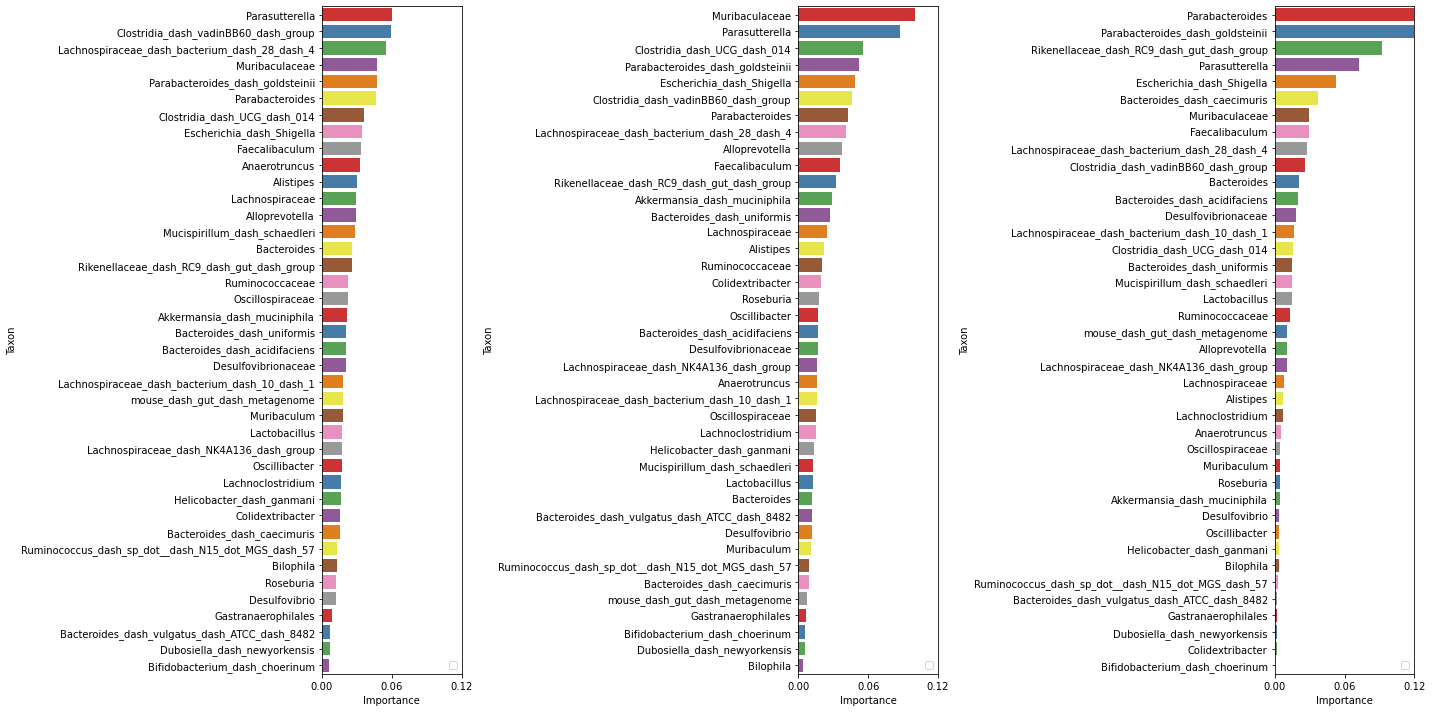

In [21]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0).set_index('SCFA')

fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=3, constrained_layout=True)
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_rf.loc[scfa].reset_index()
    curr_df.columns = ['SCFA','Taxon','Importance']
    curr_df = curr_df.sort_values('Importance',ascending=False)
    _ = sns.barplot(y='Taxon', x='Importance',  data=curr_df, orient='h', ax=ax[k], palette='Set1')
    ax[k].legend(loc='lower right')
    ax[k].set_xlim(0,0.12)
    ax[k].set_xticks([0,0.06,0.12])
plt.tight_layout()

# Combine results

In [22]:
df_corr = pd.read_excel('correlation_top40.xlsx', index_col=0)
df_corr = df_corr.drop('Spearman', axis=1)
df_corr.head()

,SCFA,Variable,Pearson
0,Acetate,Muribaculaceae,-0.252873
1,Acetate,Akkermansia_dash_muciniphila,-0.129561
2,Acetate,Bacteroides_dash_acidifaciens,0.006933
3,Acetate,Faecalibaculum,-0.204028
4,Acetate,Parasutterella,-0.197488


In [23]:
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_elasnet.head()

,SCFA,Variable,Coefficient
0,Acetate,Muribaculaceae,-0.847048
1,Acetate,Akkermansia_dash_muciniphila,-0.169171
2,Acetate,Bacteroides_dash_acidifaciens,0.023936
3,Acetate,Faecalibaculum,-0.159894
4,Acetate,Parasutterella,-0.097900


In [24]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_rf.head()

,SCFA,Variable,Gini
0,Acetate,Muribaculaceae,0.047456
1,Acetate,Akkermansia_dash_muciniphila,0.021671
2,Acetate,Bacteroides_dash_acidifaciens,0.020903
3,Acetate,Faecalibaculum,0.033197
4,Acetate,Parasutterella,0.060539


In [25]:
#df_joined = pd.merge(df_rf, df_corr, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined = pd.merge(df_rf, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','ElasticNet']
df_joined['Taxon'] = [t.replace('_dash_','-').replace('_dot_','.') for t in df_joined['Taxon']]
df_joined.head()

,SCFA,Taxon,RandomForest,ElasticNet
0,Acetate,Muribaculaceae,0.047456,-0.847048
1,Acetate,Akkermansia-muciniphila,0.021671,-0.169171
2,Acetate,Bacteroides-acidifaciens,0.020903,0.023936
3,Acetate,Faecalibaculum,0.033197,-0.159894
4,Acetate,Parasutterella,0.060539,-0.097900


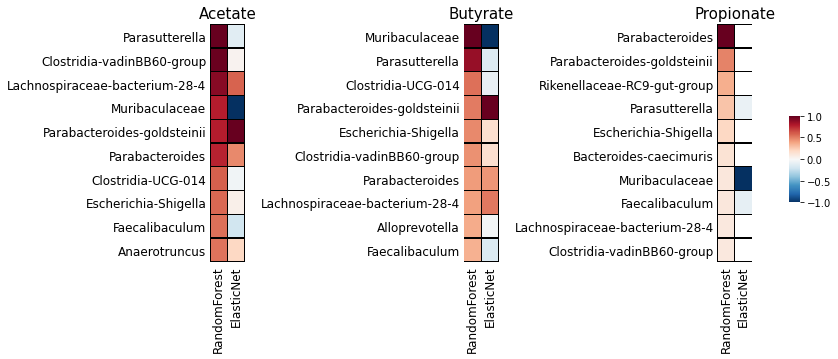

In [26]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=3, constrained_layout=True, sharex=True)
cbar_ax = fig.add_axes([0.94, .45, .015, .2])
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_joined[df_joined.SCFA==scfa].set_index('Taxon')
    curr_df = curr_df.drop('SCFA', axis=1)
    curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
    curr_df = curr_df.iloc[0:10,:] 
        
    # normalize to -1 and 1
    for c in ['ElasticNet','RandomForest']:
        if c!='RandomForest':
            curr_df.loc[curr_df[c]<0,c] = curr_df.loc[curr_df[c]<0,c]/np.abs(curr_df.loc[curr_df[c]<0,c].min())
        curr_df.loc[curr_df[c]>=0,c] = curr_df.loc[curr_df[c]>=0,c]/curr_df.loc[curr_df[c]>=0,c].max()

    # plot    
    _ = sns.heatmap(curr_df.values, ax=ax[k], cmap='RdBu_r', vmin=-1, vmax=1, cbar = False if k!=2 else True, cbar_ax = None if k!=2 else cbar_ax, linewidths=0.25, linecolor='black')
    ax[k].set_xticklabels(['RandomForest','ElasticNet'], rotation=90, fontsize=12)
    ax[k].set_title(scfa, fontsize=15)
    ax[k].set_yticklabels(curr_df.index, rotation=0, fontsize=12)
    ax[k].tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()

In [27]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_producer_top10.pdf", format="pdf")